In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

# Vector orthogonality in higher dimensions
If we pick random vectors and check their orthogonality, they are the more likely to be orthogonal the higher dimension space we sample.
* to make test invariant to rotation if we sample points from a sphere in $D$ dimensions
* we normalize lengths to extract $\vec{a} \cdot \vec{b} = |1||1|\mathrm{cos}(\alpha)= \mathrm{cos}(\alpha)$

chance to land in sectors: 8.331 %; 2*cone_size_deg/360*100 = 8.333 %
CPU times: total: 1.05 s
Wall time: 1.07 s


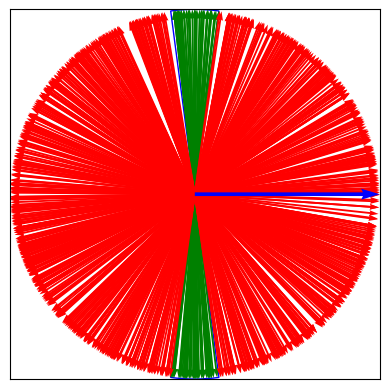

In [2]:
%%time
N = 100_000_000
cone_size_deg = 15
cone_max_angle_rad = np.deg2rad(cone_size_deg/2)

def land_in_sector(D):
    v0 = np.zeros(shape= (D,))
    v0[0] = 1
    #test_v = np.random.uniform(-1,1, size = (N,D)) # not angle-isotropic due to corners
    test_v = np.random.randn(N,D) # isotropic direction wise, not radius. but distribution is symm for any angle.
    test_v /= np.linalg.norm(test_v, axis = -1, keepdims=True)

    dots = np.abs(test_v @ v0)
 
    max_cos = np.cos(np.pi/2 - cone_max_angle_rad)

    vec_pass_mask = dots <= max_cos

    return v0, test_v, vec_pass_mask

def land_in_sector_GPU(D):
    v0 = torch.zeros(size = (D,), device= device, dtype = torch.float16)
    v0[0] = 1
    test_v = torch.randn(size = (N,D), device= device, dtype = torch.float16)   
    test_v /= torch.linalg.norm(test_v, dim= -1, keepdims= True)

    dots = torch.abs(test_v @ v0)
 
    max_cos = torch.cos(torch.pi/2 - torch.tensor(cone_max_angle_rad))

    vec_pass_mask = dots <= max_cos

    return v0.cpu().numpy(), test_v.cpu().numpy(), vec_pass_mask.cpu().numpy()

v0, test_v, vec_pass_mask = land_in_sector_GPU(D)

vec_pass_mask_old = vec_pass_mask.copy()
test_v = test_v[:1000]
vec_pass_mask = vec_pass_mask[:1000]
from matplotlib.patches import Wedge
fig, ax = plt.subplots()
patches=[Wedge((0,0), 1, np.rad2deg( np.pi/2 - cone_max_angle_rad), np.rad2deg( np.pi/2 + cone_max_angle_rad) ,edgecolor='b',facecolor='none'),
         Wedge((0,0), 1, np.rad2deg(-np.pi/2 - cone_max_angle_rad), np.rad2deg(-np.pi/2 + cone_max_angle_rad) ,edgecolor='b',facecolor='none')]

for w in patches:        
    ax.add_artist(w)

xy0s = np.zeros((2,min(1000,N)))
sc = None
un = 'xy'
w_t = 0.01
if (vec_pass_mask.sum())>0:
    ax.quiver(*xy0s[:,vec_pass_mask],*test_v[vec_pass_mask].T, width = w_t, color = 'g', units=un,  scale = 1)

if (~vec_pass_mask).sum()>0:
    ax.quiver(*xy0s[:,~vec_pass_mask],*test_v[~vec_pass_mask].T, width = w_t, color = 'r', units=un, scale = 1)

ax.quiver(0,0,*v0, width = 0.02,color = 'b', units=un,  scale = 1)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
print(f'chance to land in sectors: {(vec_pass_mask_old).sum()/N * 100:0.3f} %; {2*cone_size_deg/360*100 = :0.3f} %')
torch.cuda.empty_cache()

## 3D case: 'accretion disk'
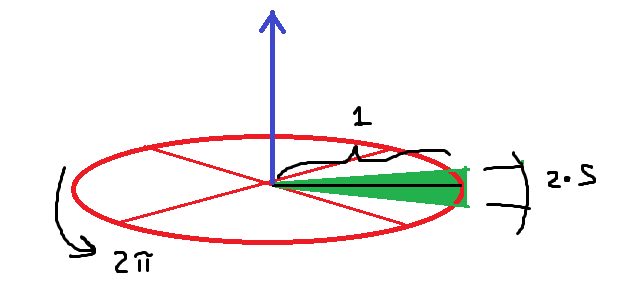

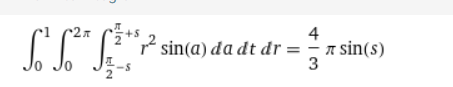

In [3]:
%%time
v0, test_v, vec_pass_mask = land_in_sector_GPU(D=3)
sphere_vol = (4/3*np.pi*1**3)

def sweep_cone(cone_half_angle):
    return (4/3*np.pi*np.sin(cone_half_angle))

cone_sweep = sweep_cone(cone_max_angle_rad)

print(f'chance to land in sector: {(vec_pass_mask).sum()/N * 100 :0.3f} %; {cone_sweep/sphere_vol*100 = :0.3f} %')

#%reset_selective -f [v0, test_v, vec_pass_mask] 
#del v0, test_v, vec_pass_mask
torch.cuda.empty_cache()

chance to land in sector: 13.061 %; cone_sweep/sphere_vol*100 = 13.053 %
CPU times: total: 922 ms
Wall time: 926 ms


## 4+ D cases

In [4]:
%%time
v0, test_v, vec_pass_mask = land_in_sector_GPU(D=4)
print(f'chance to land in sector: {(vec_pass_mask).sum()/N*100:0.3f} %')
torch.cuda.empty_cache()

chance to land in sector: 16.571 %
CPU times: total: 1.06 s
Wall time: 1.07 s


In [5]:
%%time
v0, test_v, vec_pass_mask = land_in_sector_GPU(D=5)
print(f'chance to land in sector: {(vec_pass_mask).sum()/N*100:0.3f} %')
torch.cuda.empty_cache()

chance to land in sector: 19.474 %
CPU times: total: 1.05 s
Wall time: 1.05 s


In [6]:
%%time
v0, test_v, vec_pass_mask = land_in_sector_GPU(D=15)
print(f'chance to land in sector: {(vec_pass_mask).sum()/N*100:0.3f} %')
torch.cuda.empty_cache()

chance to land in sector: 37.015 %
CPU times: total: 2.09 s
Wall time: 2.11 s
